In [1]:
import numpy as np
#import tensorflow as tf
#from tensorflow.python.client import device_lib
import pandas as pd
from zipfile import ZipFile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
#from skimage import exposure
#from skimage.color import rgb2gray
import platform
import sys
from datetime import datetime
%matplotlib inline

In [3]:
input_files = []
input_sessions = 5

samples = np.empty((0, 4))
nlabels = 0
for s in range(1, input_sessions+1):
    # read CSV file with steering angle
    csvdata = pd.read_csv("./data/driving_0" + str(s) + ".csv", header=None)
    nl = csvdata.shape[0]
    nlabels += nl
    n_ = np.vectorize(lambda x: 'driving_0' + str(s))
    
    # temporary var
    tmp = csvdata.iloc[:, [1, 3]].values
    tmp = np.concatenate((tmp, np.zeros((nl, 1))), axis=1)
    tmp = np.concatenate((tmp, n_(np.ones((nl, 1)))), axis=1)
    
    # duplicate
    tmp = np.concatenate((tmp, tmp), axis=0)
    tmp[:nl, 2] = 0 # first half
    tmp[nl:, 2] = 1 # second half
    
    # concatenate
    samples = np.concatenate((samples, tmp), axis=0)

# total samples
print(samples.shape)

# original shape
owidth = 320
oheight = 160

# crop
stripetop = 60
stripebot = 20

def generator(samples, batch_size=32):
    num_samples = len(samples)
    # 
    # Loop forever so the generator never terminates
    #  but it only executes when code calls "next()"
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                filep = batch_sample[0].split('/')
                name = './data/' + batch_sample[3] + '/' + filep[-1]
                #center_image = cv2.imread(name)
                center_image = mpimg.imread(name, format='jpeg')
                center_angle = float(batch_sample[1])
                
                if batch_sample[2]:
                    # flip image
                    center_image = np.fliplr(center_image)
                    center_angle = -center_angle
                
                # train data
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# 
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
#print(train_samples)

# Python automatically interprets the function as generator, and WON'T execute it right away
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)
# 
print(train_generator)

(10240, 4)
<generator object generator at 0x7fb390339f10>


In [4]:
print(len(train_samples))
print(samples[0])

8192
[ '/Users/bgcarvalho/Documents/Personal/pos_nanodegree_SDC/CarND-Term1-P3/data/IMG/left_2017_10_25_18_12_51_924.jpg'
 0.0 0 'driving_01']


continue

Could use sample data (provided) as test:

In [5]:
#testdata = pd.read_csv("./sample-data/driving.csv", header=None)
#y_test = y_test + testdata.iloc[:, 3]


# Model Architecture

The proposed model has 5 convolutional layers and 4 fully connected.

In [6]:
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras.layers import Cropping2D
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import __version__ as keras_version
import h5py

Using TensorFlow backend.


In [12]:
model = Sequential()

# CROP images
model.add(Cropping2D(cropping=((stripetop, stripebot), (0,0)), input_shape=(oheight, owidth, 3)))

# normalization and mean centering
model.add(Lambda(lambda x: (x / 255.0) - 0.5))

# layer 1 - convolutional
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())

# layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())

# layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(MaxPooling2D())

# layer 4
model.add(Conv2D(150, (3, 3), activation='relu'))
#model.add(MaxPooling2D())

# layer 5
model.add(Conv2D(256, (3, 3), activation='relu'))
#model.add(MaxPooling2D())


model.add(Flatten())


# layer 6
#model.add(Dense(1000))
model.add(Dense(10, activation='relu'))
#model.add(Dropout(0.5))

# layer 7
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

# layer 8
#model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.5))

# layer 9
model.add(Dense(1))

In [13]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_4 (Cropping2D)    (None, 80, 320, 3)        0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 78, 318, 32)       896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 39, 159, 32)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 37, 157, 64)       18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 78, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 76, 128)       73856     
__________

In [14]:
ee = 1e-6
cb_earlystop = EarlyStopping(min_delta=ee, patience=3, verbose=1)

# learning rate and decay over time
opt = optimizers.Adam(lr=0.001, decay=1e-6)

# compile model
model.compile(loss='mse', optimizer=opt)

# train
# samples_per_epoch=len(train_samples),
history = model.fit_generator(train_generator, 
                              validation_data=validation_generator,
                              validation_steps=len(validation_samples)/32,
                              steps_per_epoch=len(validation_samples)/32, 
                              epochs=5,
                              verbose=1)
# save to disk
model.save('model.h5')


Epoch 1/5
64/64 [==============================] - 37s - loss: 0.0565 - val_loss: 0.0388
Epoch 2/5
64/64 [==============================] - 29s - loss: 0.0453 - val_loss: 0.0388
Epoch 3/5
64/64 [==============================] - 29s - loss: 0.0570 - val_loss: 0.0389
Epoch 4/5
64/64 [==============================] - 29s - loss: 0.0477 - val_loss: 0.0388
Epoch 5/5
64/64 [==============================] - 29s - loss: 0.0548 - val_loss: 0.0389


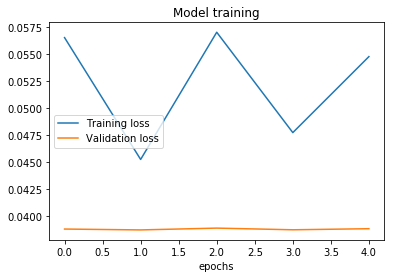

In [15]:
#print(history.history)
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('')
plt.title('Model training')
plt.legend(['Training loss', 'Validation loss'])

## Evaluate

In [ ]:
from keras.models import load_model

In [ ]:
test_generator = generator(test_samples, batch_size=32)

model.load_model('model.h5')
score = model.evaluate_generator(test_generator, batch_size=32)
print(score)